# IES nucleosome density analyses

### Input files
- file(s) containing IES IDs, IES lengths and read counts on IESs for experimental and control sampels. These files can be generated with the Prepare_input_data_for_nuc_den.ipynb jupyter notebook
- file containing IES IDs and IES retention scores of knockdowns used for filtering

#### Experimental Setup used for input files
MAC DNA of knockdown cells was purified and split into two. One half (called: DNA) was send to whole genome sequencing (WGS). The other half (called: DNase) was first treated with DNase to obtain mononucleosomes and then send for WGS. The sequencing reads were subjected to adaptor trimming (using the trimgalore module) and fastQC analysis. To count the reads mapping to IESs, the following scripts were apllied: The "DNA" reads were mapped and reads covering IESs were counted using IES_coverage_MAC_DNA.sh and the "DNase" reads were mapped and reads covering IESs were counted using IES_coverage_nucleosome_profiling.sh. 

### Output
Graphs for nucleosome density distributions, both genome-wide and filtered for certain criteria (IRSs of chosen knockdown and IES length)

### Nucleosome densities

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp # K-S test
import scipy
import math

#import merged dataframe
from create_dataframes import df2

In [2]:
def calc_nuc_den(df, dataset: str, df_columns: list):
    """
    calculates nucleosome densities and adds them to the dataframe
       
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset -- string defining dataset of interest. String will be used for column names for the 
               nucleosome density r (r_c for control and r_e for experimental sample); 
               (e.g. 'ICOP' will generate "ICOP_r_c", "ICOP_r_e" and "ICOP_re-rc")
    df_columns -- list of strings defining columns to use for calculations. Provide list in the follwing order:
                  ['DNA_exp', 'DNA_ctrl', 'DNase_exp', 'DNase_ctrl'] with "DNA" being the read counts from 
                  untreated DNA and "DNase" being the read counts from DNase treated DNA. "exp" for experimental
                  sample (e.g. ICOP1/2/PGM-KD) and "ctrl" for control sample (e.g. ND7/PGM-KD)
    
    return values:
    none
    the function will add the r_c, r_e columns to the dataframe
    
    """
    
    # store column names in valiables
    DNA_exp = df_columns[0]
    DNA_ctrl = df_columns[1]
    DNase_exp = df_columns[2]
    DNase_ctrl = df_columns[3]
    
    # select the read counts of the selected columns
    d_c = df[DNA_ctrl]
    n_c = df[DNase_ctrl]
    d_e = df[DNA_exp]
    n_e = df[DNase_exp]
    
    #Summary statistics of reads mapped to IESs:
    D_c, D_e = sum(d_c), sum(d_e)
    N_c, N_e = sum(n_c), sum(n_e)
    
    #add DNA-seq normalized nucleosome densities to dataframe for ICOP1_2-KD:

    df[f"{dataset}_r_c"] = (n_c/N_c)/(d_c/D_c)
    df[f"{dataset}_r_e"] = (n_e/N_e)/(d_e/D_e)    

In [3]:
def select_subsets_den(df, dataset, IRS_KD, IRS_threshold = 0.2, len_threshold = 200):
    """
    select nucleosome density subsets according to IES length and IRS threshold
    
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset -- string defining dataset of interest. String needs to match the nucleosome density column names
               in the data frame; includes experimental and control sample (e.g. 'ICOP' for "ICOP_r_c" and 
               "ICOP_r_e")
    IRS_KD -- string defining column in the data frame containing IRSs that should be used for 
              filtering highly or lowly retained IESs (e.g. 'ICOP1_2-KD'). If no threshold should be applied
              use "None"
    IRS_threshold -- float (0 to 1) defining IESs considered with low (IES retention < IRS_threshold) 
                     or high retention (IES retention >= IRS_threshold). If no threshold should be applied, 
                     use "None"
                     (default 0.2)
    len_threshold -- integer (higher 0) defining IES considered short (IES length < len_threshold) 
                     or long (IES length >= len_threshold). 
                     (default 200)
    
    return values:
    dictionary with subset names as keys and nucleosome densities (as pandas series) as values. Depending 
    on the applied thresholds, varying number of substsets will be generated. Subsets are gereated for both
    control and experimental sample
    
    """
    
    r_c = f"{dataset}_r_c"
    r_e = f"{dataset}_r_e" 
    
    # all nucleosome densities
    ctrl = df[(~np.isnan(df[r_c])) & (~np.isinf(df[r_c]))][r_c]
    exp = df[(~np.isnan(df[r_e])) & (~np.isinf(df[r_e]))][r_e]
       
    # nucleosome density subsets according to IRS thresholds
    if IRS_threshold != None and 0 <= IRS_threshold <= 1:
        # Filter subsets based on IRS threshold
        low = df[df[IRS_KD] < IRS_threshold]
        high = df[df[IRS_KD] >= IRS_threshold]
        
        low_ctrl = low[(~np.isnan(low[r_c])) & (~np.isinf(low[r_c]))][r_c]
        high_ctrl = high[(~np.isnan(high[r_c])) & (~np.isinf(high[r_c]))][r_c]
        low_exp = low[(~np.isnan(low[r_e])) & (~np.isinf(low[r_e]))][r_e]
        high_exp = high[(~np.isnan(high[r_e])) & (~np.isinf(high[r_e]))][r_e]

    # nucleosome density subsets according to length thresholds      
    if len_threshold != None and len_threshold >= 0:
        # Filter based on IES length
        short = df[df['IES_length'] < len_threshold]
        long = df[df['IES_length'] >= len_threshold]
        
        short_ctrl = short[(~np.isnan(short[r_c])) & (~ np.isinf(short[r_c]))][r_c]
        long_ctrl = long[(~np.isnan(long[r_c])) & (~np.isinf(long[r_c]))][r_c]
        short_exp = short[(~np.isnan(short[r_e])) & (~np.isinf(short[r_e]))][r_e]
        long_exp = long[(~np.isnan(long[r_e])) & (~np.isinf(long[r_e]))][r_e]    
    
    # nucleosome density subsets according to IRS threshold and IES length threshold
    if IRS_threshold != None and len_threshold != None and 0 <= IRS_threshold <= 1 and len_threshold >= 0:
        low_short_ctrl = low[(low['IES_length'] < len_threshold) 
                             & (~np.isnan(low[r_c])) & (~ np.isinf(low[r_c]))][r_c]                 
        low_long_ctrl = low[(low['IES_length'] >= len_threshold) 
                            & (~np.isnan(low[r_c])) & (~np.isinf(low[r_c]))][r_c]
        high_short_ctrl = high[(high['IES_length'] < len_threshold) 
                               & (~np.isnan(high[r_c])) & (~np.isinf(high[r_c]))][r_c]
        high_long_ctrl = high[(high['IES_length'] >= len_threshold) 
                              & (~np.isnan(high[r_c])) & (~np.isinf(high[r_c]))][r_c]
        low_short_exp = low[(low['IES_length'] < len_threshold) 
                            & (~np.isnan(low[r_e])) & (~np.isinf(low[r_e]))][r_e]                 
        low_long_exp = low[(low['IES_length'] >= len_threshold) 
                           & (~np.isnan(low[r_e])) & (~np.isinf(low[r_e]))][r_e]
        high_short_exp = high[(high['IES_length'] < len_threshold) 
                               & (~np.isnan(high[r_e])) & (~np.isinf(high[r_e]))][r_e]
        high_long_exp = high[(high['IES_length'] >= len_threshold) 
                              & (~np.isnan(high[r_e])) & (~np.isinf(high[r_e]))][r_e]
    
    # Return all generated subsets
        return {
            'ctrl': ctrl,
            'exp': exp,
            'low_ctrl': low_ctrl,
            'high_ctrl': high_ctrl,
            'short_ctrl': short_ctrl,
            'long_ctrl': long_ctrl,
            'low_exp': low_exp,
            'high_exp': high_exp,
            'short_exp': short_exp,
            'long_exp': long_exp,
            'low_short_ctrl': low_short_ctrl,
            'high_short_ctrl': high_short_ctrl,
            'low_long_ctrl': low_long_ctrl,
            'high_long_ctrl': high_long_ctrl,
            'low_short_exp': low_short_exp,
            'high_short_exp': high_short_exp,
            'low_long_exp': low_long_exp,
            'high_long_exp': high_long_exp
        }
    
    # if no len_threshold is given
    if IRS_threshold != None and 0 <= IRS_threshold <= 1 and len_threshold == None:
        return {
            'ctrl': ctrl,
            'exp': exp,
            'low_ctrl': low_ctrl,
            'high_ctrl': high_ctrl,
            'low_exp': low_exp,
            'high_exp': high_exp
        }
    # if no IRS_threshold is given
    elif len_threshold != None and len_threshold >= 0:
        return {
            'ctrl': ctrl,
            'exp': exp,
            'short_ctrl': short_ctrl,
            'long_ctrl': long_ctrl,
            'short_exp': short_exp,
            'long_exp': long_exp
        }
    # if no threshold is given
    elif IRS_threshold == None and len_threshold == None:
        return {
            'ctrl': ctrl,
            'exp': exp
        }

    else:
        print('Provided arguments are not valid')

In [4]:
def ks_statistics_den(df, dataset, IRS_KD, IRS_threshold = 0.2, len_threshold = 200):
    """
    calculate ks statistics for nucleodesity subsets
    
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset -- string defining dataset of interest. String needs to match the nucleosome density column names
               in the data frame; includes experimental and control sample (e.g. 'ICOP' for "ICOP_r_c" and 
               "ICOP_r_e")
    IRS_KD -- string defining column in the data frame containing IRSs that should be used for 
              filtering highly or lowly retained IESs (e.g. 'ICOP1_2-KD'). If no threshold should be applied,
              use "None"
    IRS_threshold -- flaot (0 to 1) defining IESs considered with low (IES retention < IRS_threshold) 
                     or high retention (IES retention >= IRS_threshold). If no threshold should be applied,
                     use "None"
                     (default 0.2)
    len_threshold -- integer (higher 0) defining IES considered short (IES length < len_threshold) 
                     or long (IES length >= len_threshold). If no threshold should be applied,
                     use "None"
                     (default 200)
    
    return values:
    dictionary with subset names as keys and ks statistics as values. Depending 
    on the applied thresholds, varying number of substsets will be generated. 
    
    """
    
    # select the subsets:
    subsets = select_subsets_den(df, dataset, IRS_KD, IRS_threshold, len_threshold)

    
    #calculate KS two sample test statistics
    total_ks = ks_2samp(subsets['ctrl'], subsets['exp'])
    
    if IRS_threshold != None and 0 <= IRS_threshold <= 1:
        low_ks = ks_2samp(subsets['low_ctrl'], subsets['low_exp'])
        high_ks = ks_2samp(subsets['high_ctrl'], subsets['high_exp'])
        
    if len_threshold != None and len_threshold >= 0:
        short_ks = ks_2samp(subsets['short_ctrl'], subsets['short_exp'])
        long_ks = ks_2samp(subsets['long_ctrl'], subsets['long_exp'])
        
    if IRS_threshold != None and 0 <= IRS_threshold <= 1 \
    and len_threshold != None and len_threshold >= 0:
        low_short_ks = ks_2samp(subsets['low_short_ctrl'], subsets['low_short_exp'])
        low_long_ks = ks_2samp(subsets['low_long_ctrl'], subsets['low_long_exp'])
        high_short_ks = ks_2samp(subsets['low_short_ctrl'], subsets['low_short_exp'])
        high_long_ks = ks_2samp(subsets['high_long_ctrl'], subsets['high_long_exp'])
    
    # Return generated statistics
    if IRS_threshold != None and 0 <= IRS_threshold <= 1 \
    and len_threshold != None and len_threshold >= 0:
        return {
            'total_ks': total_ks,
            'low_ks': low_ks,
            'high_ks': high_ks,
            'short_ks': short_ks,
            'long_ks': long_ks,
            'low_short_ks': low_short_ks,
            'low_long_ks': low_long_ks,
            'high_short_ks': high_short_ks,
            'high_long_ks': high_long_ks
        }
    
    # if no len_threshold is given
    elif IRS_threshold != None and 0 <= IRS_threshold <= 1 and len_threshold == None:
        return {
            'total_ks': total_ks,
            'low_ks': low_ks,
            'high_ks': high_ks
        }
    
    # if no IRS_threshold is given
    elif IRS_threshold == None and len_threshold != None and len_threshold >= 0:
        return {
            'total_ks': total_ks,
            'short_ks': short_ks,
            'long_ks': long_ks
        }
    
    # if no threshold is given
    elif IRS_threshold == None and len_threshold == None:
        return {
            'total_ks': total_ks
        }
    
    # if invalid arguments are given
    else:
        print('Provided arguments are not valid')


In [5]:
def hist_tot_nuc_den(df, dataset, labels, colors, save = False):
    """    
    generate histogram of nucleosome densities on all IES for specified dataset
    
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset -- string defining dataset of interest. String needs to match the nucleosome density column names
             in the data frame; includes experimental and control sample (e.g. 'ICOP' for "ICOP_r_c" and 
             "ICOP_r_e")
    lables -- list providing samples names on the figure ledgend: ['control','experimental']
            (e.g. ['ND7/PGM-KD', 'ICOP1/2/PGM-KD'])
    colors -- list providing colors to be used for the samples: ['control','experimental']
            (e.g. ['teal','darksalmon'])
    save -- True or False: whether the plot should be saved 
          (default Flase)
          
    return values:
    none
    the function will generate a histogram. If Save = True it will save the image as .pdf file
    
    """
    
    
    # use function to retrieve nucleosome densities of all IESs in selected dataset
    dset = select_subsets_den (df, dataset, None, IRS_threshold = None, len_threshold = None)
    ctrl = dset['ctrl']
    exp = dset['exp']
    
    # retrieve the KS statistics
    ks_stats = ks_statistics_den(df, dataset, None, IRS_threshold = None, len_threshold = None)
    
    #Summary stats and check on number of measurements after filtering of "nan" and "inf" values resulting from division by 0
    print(np.mean(ctrl), np.mean(exp))
    print(len(ctrl), len(exp))
    
    #generate a histogram
    plt.figure(figsize=(10,6))
    plt.hist((ctrl, exp), bins=np.arange(0, 5, 0.1), label=labels, 
             color = colors, ec = 'white', lw=1)
    plt.xlabel("Normalized nucleosome density", fontsize=28)
    plt.ylabel("Number of IESs", fontsize=28)
    plt.legend(fontsize=20)
    plt.xlim(0,4.5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # add KS statistics
    plt.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['total_ks'][0], ks_stats['total_ks'][1]),
                xy = (0.65,0.4),xycoords='axes fraction',fontsize=18) 
    
    if save:
        plt.savefig(f"output_files/{dataset}_totalNu-den.pdf")

In [6]:
# add nucleosome densities 
ICOP_cols = ["ICOP1_2_PGM_MAC", "ND7_PGM_MAC", "ICOP1_2_PGM_DNase", "ND7_PGM_DNase"]
ISWI_cols = ["ISWPGM_MAC", "PGM_MAC", "I1Pg18", "Pg18"]
NOWA_cols = ["N1Pgm_N1_MP", "EV_PGM_N1_MP", "NOWA1_Pg", "EV_Pg"]
PTCAF_cols = ["PtCAF1_PGM_MP", "EV_PGM_MP", "PtCAF1_PGM_NP", "EV_PGM_NP"]
calc_nuc_den(df2, "ICOP", ICOP_cols)
calc_nuc_den(df2, "ISWI", ISWI_cols)
calc_nuc_den(df2, "NOWA", NOWA_cols)
calc_nuc_den(df2, "PTCAF", PTCAF_cols)
df2[:5]

,IES_length,ND7_PGM_DNase,ND7_PGM_MAC,ICOP1_2_PGM_DNase,ICOP1_2_PGM_MAC,PGM_MAC,Pg18,ISWPGM_MAC,I1Pg18,EV_PGM_N1_MP,...,PtCAF1_PGM_NP,ICOP1_2-KD,ICOP_r_c,ICOP_r_e,ISWI_r_c,ISWI_r_e,NOWA_r_c,NOWA_r_e,PTCAF_r_c,PTCAF_r_e
IES,,,,,,,,,,,,,,,,,,,,,
IESPGM.PTET51.1.9.2325,495,642,69,846,126,43,147,88,255,71,...,31,0.0606,1.660514,1.760649,3.157974,1.775483,1.622271,1.377556,1.875006,1.140507
IESPGM.PTET51.1.9.33017,65,30,10,43,31,31,4,30,27,26,...,0,0.0000,0.535399,0.363731,0.119195,0.551444,0.142905,0.973473,0.200844,0.000000
IESPGM.PTET51.1.9.35389,133,221,38,278,56,28,28,32,62,19,...,2,0.0244,1.037923,1.301756,0.923761,1.187137,1.955539,0.265493,1.747346,0.173015
IESPGM.PTET51.1.9.36829,73,19,15,11,10,15,1,8,20,7,...,0,0.0370,0.226057,0.288447,0.061584,1.531789,0.530789,0.973473,0.364030,0.000000
IESPGM.PTET51.1.9.36845,106,305,21,290,23,16,20,17,83,12,...,5,0.0333,2.592012,3.306307,1.154701,2.991495,1.857762,7.301049,1.456122,1.143135


1.017306712033577 0.987396440688342
44527 44648


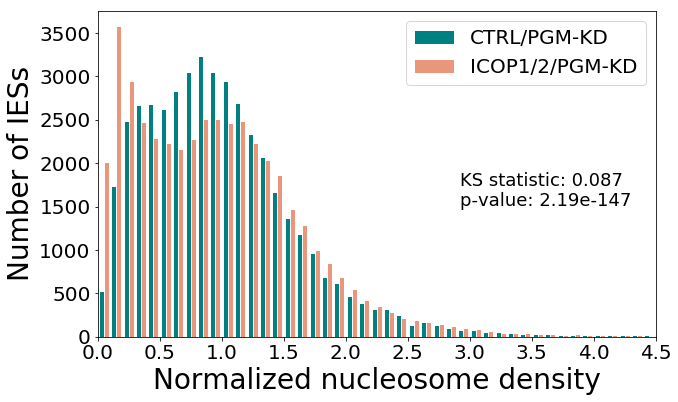

In [7]:
hist_tot_nuc_den(df2, 'ICOP', ['CTRL/PGM-KD', 'ICOP1/2/PGM-KD'], ['teal','darksalmon'], save = True)

1.0205669933934436 1.0048925209616308
44490 44555


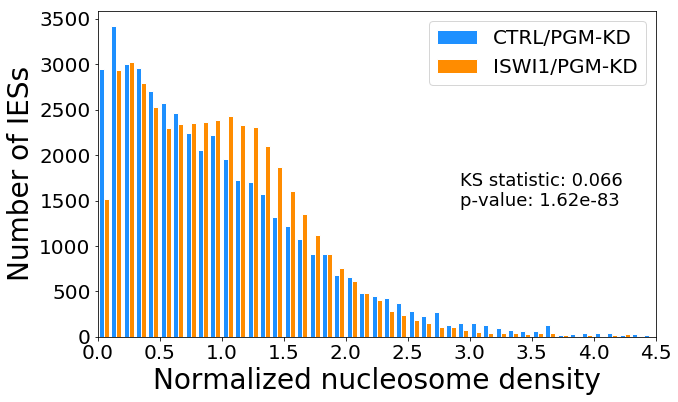

In [8]:
hist_tot_nuc_den(df2, 'ISWI', ['CTRL/PGM-KD', 'ISWI1/PGM-KD'], ['dodgerblue','darkorange'])

1.0488102578489102 1.0882171811193015
44433 43604


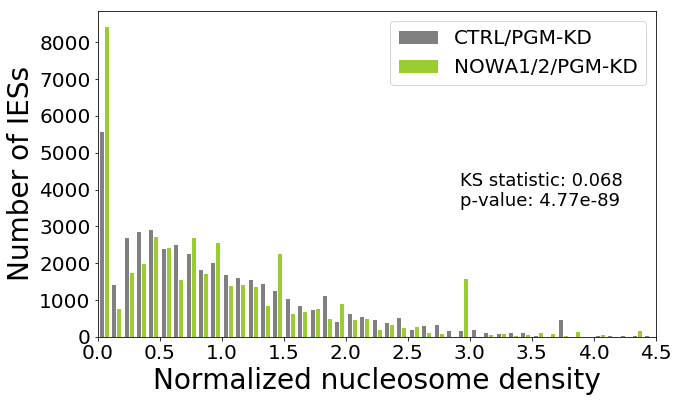

In [9]:
hist_tot_nuc_den(df2, 'NOWA', ['CTRL/PGM-KD', 'NOWA1/2/PGM-KD'], ['grey','yellowgreen'])

1.0421964230105523 1.0075234699969393
44450 44433


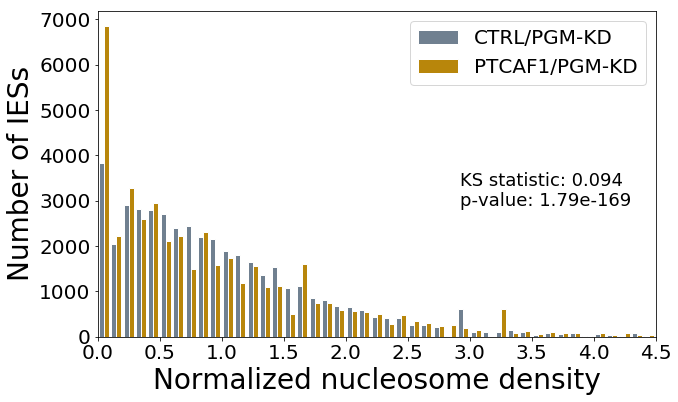

In [10]:
hist_tot_nuc_den(df2, 'PTCAF', ['CTRL/PGM-KD', 'PTCAF1/PGM-KD'], ['slategrey','darkgoldenrod'])

In [11]:
def hist_nuc_den(df, dataset, IRS_KD, labels, colors, IRS_threshold=0.2, len_threshold=200, save=False):
    """    
    generate histogram of nucleosome densities on IES subsets for specified dataset
    
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset -- string defining dataset of interest. String needs to match the nucleosome density column names
             in the data frame; includes experimental and control sample (e.g. 'ICOP' for "ICOP_r_c" and 
             "ICOP_r_e")
    IRS_KD -- string defining column in the data frame containing IRSs (IES retention scores) that should 
            be used for filtering highly or lowly retained IESs (e.g. 'ICOP1_2_IRS'). If no filtering for IRS
            is applied, procide any argument (will not be used)
    IRS_threshold -- flaot (0 to 1) defining IESs considered with low (IES retention < IRS_threshold) 
                   or high retention (IES retention >= IRS_threshold). 
                   If no threshold should be applied use None 
                   (default 0.2)
    len_threshold -- integer (higher 0) defining IES considered short (IES length < len_threshold) 
                   or long (IES length >= len_threshold). 
                   If no threshold should be applied use None 
                   (default 200)
    lables -- list providing samples names on the figure ledgend: ['control','experimental']
            (e.g. ['ND7/PGM-KD', 'ICOP1/2/PGM-KD'])
    colors -- list providing colors to be used for the samples: ['control','experimental']
            (e.g. ['teal','darksalmon'])
    save -- True or False: whether the plot should be saved 
          (default Flase)
    
    return values:
    none
    the function will generate a histogram. If Save = True it will save the image as .pdf file
    
    """
    
    # retrieve the subsets
    subs = select_subsets_den(df, dataset, IRS_KD, IRS_threshold=0.2, len_threshold=200)
    ks_stats = ks_statistics_den(df, dataset, IRS_KD, IRS_threshold = 0.2, len_threshold = 200)
    
    IRS_KD_label = f"{IRS_KD}".replace("_","/")
    
    fig, axes = plt.subplots(4, 2, figsize=(12,10))
    ax1, ax2 = axes[0]
    ax3, ax4 = axes[1]
    ax5, ax6 = axes[2]
    ax7, ax8 = axes[3]
    
    
    ax1.hist((subs['low_ctrl'], subs['low_exp']), bins=np.arange(0, 5, 0.1), 
              color=colors, ec = 'white', lw=1, label=labels)
    ax1.set_title(f"low\n{IRS_KD_label} IRS < {IRS_threshold}", fontsize=14)

    ax2.hist((subs['high_ctrl'], subs['high_exp']), bins=np.arange(0, 5, 0.1), 
              color=colors, ec = 'white', lw=1, label=labels)
    ax2.set_title(f"high\n{IRS_KD_label} IRS >= {IRS_threshold}", fontsize=14)

    ax3.hist((subs['short_ctrl'], subs['short_exp']), bins=np.arange(0, 5, 0.1),
             color=colors, ec = 'white', lw=1, label=labels)
    ax3.set_title(f"short\nIES length < {len_threshold} bp", fontsize=14)

    ax4.hist((subs['long_ctrl'], subs['long_exp']), bins=np.arange(0, 5, 0.1),
             color=colors, ec = 'white', lw=1, label=labels)
    ax4.set_title(f"long\nIES length >= {len_threshold} bp", fontsize=14)

    ax5.hist((subs['low_short_ctrl'], subs['low_short_exp']), bins=np.arange(0, 5, 0.1),
             color=colors, ec = 'white', lw=1, label=labels)
    ax5.set_title(f"low_short\n{IRS_KD_label} IRS < {IRS_threshold}, IES length < {len_threshold} bp", 
                  fontsize=14)

    ax6.hist((subs['high_short_ctrl'], subs['high_short_exp']), bins=np.arange(0, 5, 0.1),
             color=colors, ec = 'white', lw=1, label=labels)
    ax6.set_title(f"high_short\n{IRS_KD_label} IRS >= {IRS_threshold}, IES length < {len_threshold} bp", 
                  fontsize=14)

    ax7.hist((subs['low_long_ctrl'], subs['low_long_exp']), bins=np.arange(0, 5, 0.1),
             color=colors, ec = 'white', lw=1, label=labels)
    ax7.set_title(f"low_long\n{IRS_KD_label} IRS < {IRS_threshold}, IES length >= {len_threshold} bp", 
                  fontsize=14)

    ax8.hist((subs['high_long_ctrl'], subs['high_long_exp']), bins=np.arange(0, 5, 0.1),
             color=colors, ec = 'white', lw=1, label=labels)
    ax8.set_title(f"high_long\n{IRS_KD_label} IRS >= {IRS_threshold}, IES length >= {len_threshold} bp", 
                  fontsize=14)

    # set x-axis limits
    ax1.set_xlim([0,5])
    ax2.set_xlim([0,5])
    ax3.set_xlim([0,5])
    ax4.set_xlim([0,5])
    ax5.set_xlim([0,5])
    ax6.set_xlim([0,5])
    ax7.set_xlim([0,5])
    ax8.set_xlim([0,5])

    # set the font size of the axis ticks
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    ax4.tick_params(axis='both', which='major', labelsize=14)
    ax5.tick_params(axis='both', which='major', labelsize=14)
    ax6.tick_params(axis='both', which='major', labelsize=14)
    ax7.tick_params(axis='both', which='major', labelsize=14)
    ax8.tick_params(axis='both', which='major', labelsize=14)


    # include KS-statistic
    text_pos = (0.64,0.29)
    ax1.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['low_ks'][0], ks_stats['low_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax2.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['high_ks'][0], ks_stats['high_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax3.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['short_ks'][0], ks_stats['short_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax4.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['long_ks'][0], ks_stats['long_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax5.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['low_short_ks'][0], ks_stats['low_short_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax6.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['high_short_ks'][0], ks_stats['high_short_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax7.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['low_long_ks'][0], ks_stats['low_long_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax8.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['high_long_ks'][0], ks_stats['high_long_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    


    #ax2.legend(bbox_to_anchor=(0.6, 1.03), fontsize=13, framealpha=1)
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.51, 1.02), fontsize=13)

    fig.text(0.5, 0.01, 'DNA-seq normalized nucleosome density on IES', ha='center', fontsize=18)
    fig.text(0.001, 0.5, 'Number of IESs', ha='center', fontsize=18, rotation='vertical')


    fig.tight_layout(rect=[0.01, 0.04, 1, 1])
    
    if save:
        fig.savefig(f"output_files/{dataset}_{IRS_KD}_{IRS_threshold}_{len_threshold}_subsNu-den.pdf",
                    bbox_inches = 'tight')
        
    

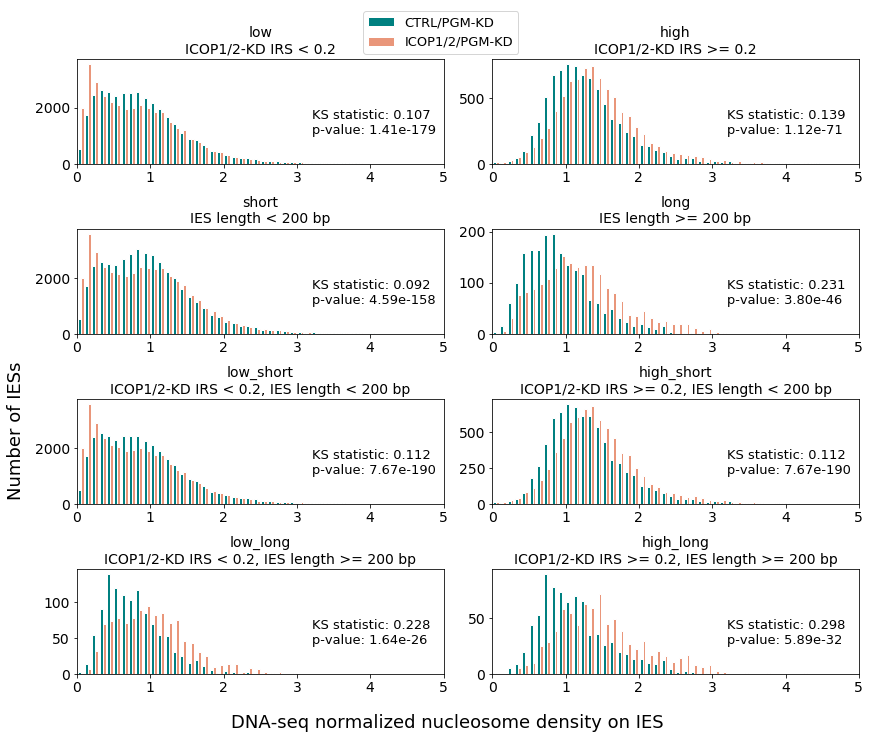

In [12]:
hist_nuc_den(df2, 'ICOP', 'ICOP1_2-KD', ['CTRL/PGM-KD', 'ICOP1/2/PGM-KD'], ['teal','darksalmon'], save = True)


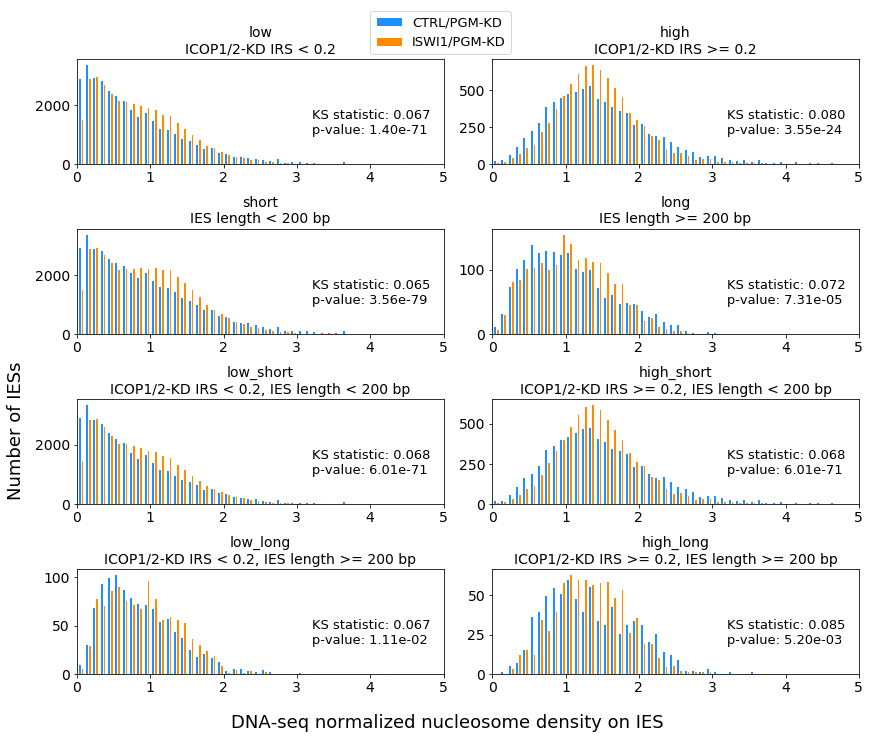

In [13]:
hist_nuc_den(df2, 'ISWI', 'ICOP1_2-KD', ['CTRL/PGM-KD', 'ISWI1/PGM-KD'], ['dodgerblue','darkorange'])

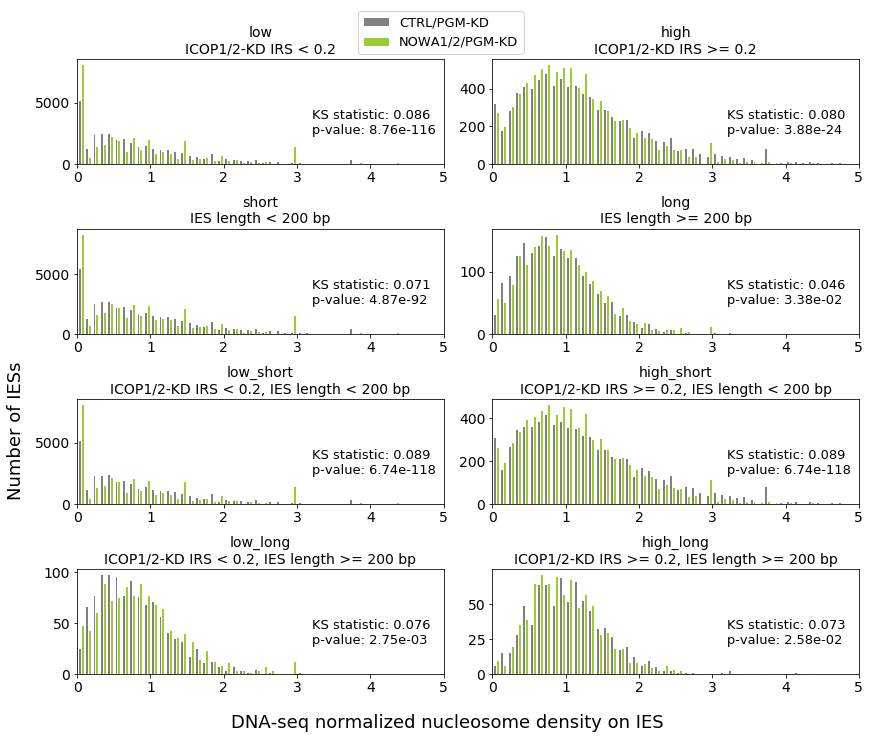

In [14]:
hist_nuc_den(df2, 'NOWA', 'ICOP1_2-KD', ['CTRL/PGM-KD', 'NOWA1/2/PGM-KD'], ['grey','yellowgreen'])

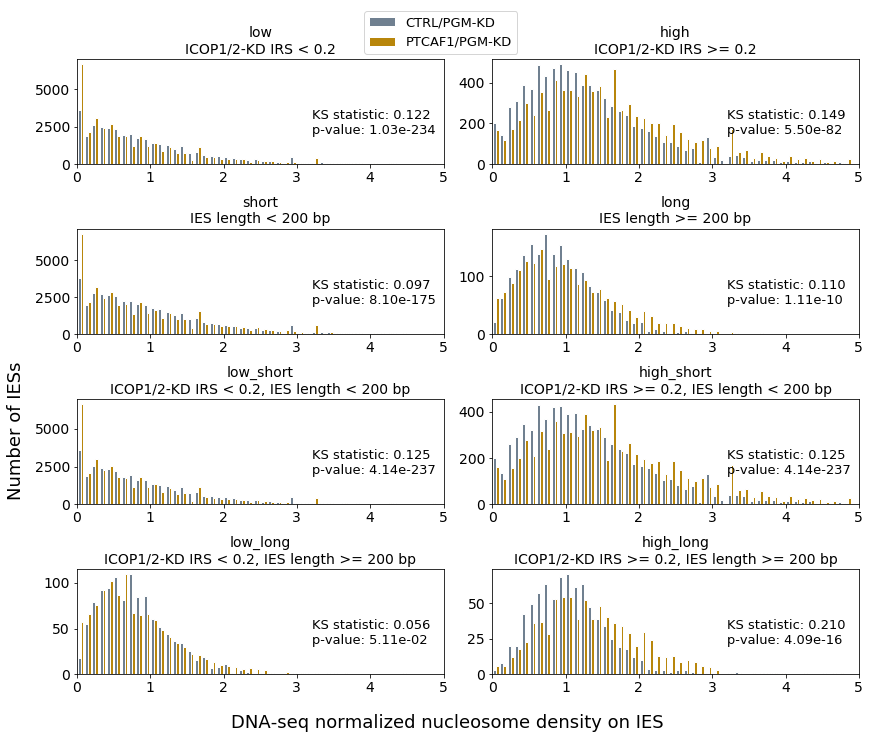

In [15]:
hist_nuc_den(df2, 'PTCAF', 'ICOP1_2-KD', ['CTRL/PGM-KD', 'PTCAF1/PGM-KD'], ['slategrey','darkgoldenrod'])